In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random
import secrets
import sqlite3
from collections import Counter
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from itertools import cycle
sns.set_style('whitegrid')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb

Functions created specifically for this casestudy are saved in a seperate file, `bellabeat_fitbit_analysis_functions.py` and loaded in here. Use this file as reference for more detail on how the data is specfically processed, analyzed or visualized.

In [3]:
# functions written specifically to analyze bellabeat/fitbit data
from bellabeat_fitbit_analysis_functions import *

### Aquiring data from .csv files and SQL queries
This data will be turned into datasets which will be tested for their ability for predicting Calories burnt on a given day.

In [4]:
### DailyActivity data loaded into useful DataFrame format
dailyActivity = pd.read_csv('data_processed/dailyActivity_processed.csv')
dailyActivity['ModeratelyActiveMinutes'] = dailyActivity[['VeryActiveMinutes', 'FairlyActiveMinutes']].apply(lambda x: (x.values.sum()), axis="columns")
dailyActivity['ActiveMinutes'] = dailyActivity[['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes']].apply(lambda x: (x.values.sum()), axis="columns")
dailyActivity['Id_dt_string'] = dailyActivity[['Id', 'dtString']].apply(lambda x: ' '.join(x.values.astype(str)), axis="columns")

In [5]:
# check to make sure the columns with combined activity minutes are calculated properly 
dailyActivity['ModeratelyActiveMinutes_delta'] = dailyActivity[['VeryActiveMinutes', 'FairlyActiveMinutes', 'ModeratelyActiveMinutes']].apply(lambda x: (x.values[2] - (x.values[0] + x.values[1])), axis="columns")
dailyActivity['ActiveMinutes_delta'] = dailyActivity[['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'ActiveMinutes']].apply(lambda x: (x.values[3] - (x.values[0] + x.values[1] + x.values[2])), axis="columns")
ModeratelyActiveCol_check = dailyActivity[dailyActivity['ModeratelyActiveMinutes_delta'] != 0].shape
print('ModeratelyActiveMinutes column is calculated properly:')
print(f'{ModeratelyActiveCol_check[0] == 0}')
ActiveCol_check = dailyActivity[dailyActivity['ActiveMinutes_delta'] != 0].shape
print('ActiveMinutes column is calculated properly:')
print(f'{ActiveCol_check[0] == 0}')
dailyActivity = dailyActivity.drop(columns=['ModeratelyActiveMinutes_delta', 'ActiveMinutes_delta'])

ModeratelyActiveMinutes column is calculated properly:
True
ActiveMinutes column is calculated properly:
True


In [6]:
### DailySleep data loaded into useful DataFrame format
dailySleep_query = """SELECT  a.Id, a.dtString, a.wkDay, a.TotalSteps, a.TotalDistance, a.VeryActiveMinutes,  
                        a.FairlyActiveMinutes, a.LightlyActiveMinutes, a.SedentaryMinutes, a.Calories,  
                        s.totalSleepMinute, s.totalSleepQuality, sl.TotalTimeInBed
                      FROM dailyActivity_processed a  
                      JOIN dailySleep_generated s ON s.Id = a.Id AND s.dtString = a.dtString   
                      JOIN dailySleep_processed sl ON sl.Id = a.Id AND sl.dtString = a.dtString; """

# call sql_query() and turn into a DataFrame
dailySleep_query_result = sql_query(dailySleep_query)
col_names = ['Id', 'dtString', 'wkDay', 'TotalSteps', 'TotalDistance', 'VeryActiveMinutes',  
             'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 
             'Calories', 'totalSleepMinute', 'totalSleepQuality', 'TotalTimeInBed']
dailySleep = pd.DataFrame(dailySleep_query_result, columns = col_names)

dailySleep['SleepRatio'] = dailySleep['totalSleepQuality'] / dailySleep['totalSleepMinute']
dailySleep['totalSleepHour'] = round(dailySleep['totalSleepMinute'] / 60, 2)
dailySleep['TotalTimeInBedHour'] = round(dailySleep['TotalTimeInBed'] / 60, 2)
dailySleep['Id_dt_string'] = dailySleep[['Id', 'dtString']].apply(lambda x: ' '.join(x.values.astype(str)), axis="columns")

In [7]:
dailyStats = dailyActivity.merge(dailySleep, on='Id_dt_string', how='inner', suffixes=['_activity', '_sleep'])
dailyStats = dailyStats[['Id_activity', 'dtString_activity', 'month', 'day', 'wkDay_activity', 'TotalSteps_activity', 'TotalDistance_activity', 'TrackerDistance',
                    'LoggedActivitiesDistance', 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance',
                    'VeryActiveMinutes_activity', 'FairlyActiveMinutes_activity', 'LightlyActiveMinutes_activity','SedentaryMinutes_activity', 'ModeratelyActiveMinutes',
                    'ActiveMinutes', 'totalSleepMinute', 'totalSleepQuality', 'TotalTimeInBed', 'SleepRatio', 'totalSleepHour', 'TotalTimeInBedHour', 'Calories_activity']]

dailyStats.columns = ['Id', 'dtString', 'month', 'day', 'wkDay', 'TotalSteps', 'TotalDistance', 'TrackerDistance',
                    'LoggedActivitiesDistance', 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance',
                    'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes','SedentaryMinutes', 'ActiveMinutes', 'ModeratelyActiveMinutes', 
                    'totalSleepMinute', 'totalSleepQuality', 'TotalTimeInBed', 'SleepRatio', 'totalSleepHour', 'TotalTimeInBedHour', 'Calories']

# Dataset 1
just daily activity with the most data points

In [8]:
dataset1 = dailyActivity.copy()

In [9]:
dataset1_weightsAndScores = generate_activity_minutes_weights(dataset1, ['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes'], ['Calories'])

Trial 1
r2 score is: 0.3310619245682923
mean_sqrd_error is: 278955.6965547794
root_mean_squared_error of is: 528.1625664080893
Trial 2
r2 score is: 0.4426029053276074
mean_sqrd_error is: 260926.74962731547
root_mean_squared_error of is: 510.80989578052953
Trial 3
r2 score is: 0.3325216290049722
mean_sqrd_error is: 273339.36191864393
root_mean_squared_error of is: 522.818670208557


In [10]:
dataset1_weights = generate_mean_weights(dataset1_weightsAndScores)

# Dataset 2
both daily activity and daily sleep combined

In [11]:
dataset2 = dailyStats.copy()

Creating a common column to join data tables

In [12]:
dataset2['Id_month_day'] = dataset2[['Id', 'month', 'day']].apply(lambda x: ' '.join(x.values.astype(str)), axis="columns")

In [13]:
dataset2_weightsAndScores = generate_activity_minutes_weights(dataset2, ['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes'], ['Calories'])

Trial 1
r2 score is: 0.3178872506309478
mean_sqrd_error is: 367758.66997990996
root_mean_squared_error of is: 606.4310925240476
Trial 2
r2 score is: 0.44604757996459365
mean_sqrd_error is: 335750.47379696596
root_mean_squared_error of is: 579.4397930734184
Trial 3
r2 score is: 0.41818987047214595
mean_sqrd_error is: 293405.2278360506
root_mean_squared_error of is: 541.6689282541972


In [14]:
dataset2_weights = generate_mean_weights(dataset2_weightsAndScores)

# Dataset 3
daily activity and daily sleep combined with daily resting heartrate (both steps and METs)

In [15]:
### Resting Heartrate by Steps
restingHeartrate_Id_viaSteps_query = """SELECT h.Id, h.month, h.day, AVG(h.mean) AS meanRestingHeartrate
FROM hourlyHeartrate_generated h
JOIN hourlySteps_processed st ON st.Id = h.Id AND st.dtString = h.dtString
WHERE st.StepTotal = 0
GROUP BY h.Id, h.month, h.day;"""
col_names = ['Id', 'month', 'day', 'meanRestingHeartrate']
restingHeartrate_Id_viaSteps = query_to_df(restingHeartrate_Id_viaSteps_query, col_names, Id_incl=True)
restingHeartrate_Id_viaSteps['Id_month_day'] = restingHeartrate_Id_viaSteps[['Id', 'month', 'day']].apply(lambda x: ' '.join(x.values.astype(str)), axis="columns")
restingHeartrate_Id_viaSteps.head()

,Id,month,day,meanRestingHeartrate,Id_month_day
0,2022484408,4,16,72.000000,2022484408 4 16
1,2022484408,4,21,69.000000,2022484408 4 21
2,2022484408,4,24,75.828125,2022484408 4 24
3,2022484408,4,27,70.000000,2022484408 4 27
4,2022484408,4,30,79.000000,2022484408 4 30


In [18]:
### Resting Heartrate by METs
restingHeartrateviaMETs_Id_query = """SELECT h.Id, h.month, h.day, AVG(h.mean) AS meanRestingHeartrate
FROM hourlyHeartrate_generated h  
JOIN hourlyMETs_generated m ON m.Id = h.Id AND m.dtString = h.dtString 
WHERE m.METS < 660
GROUP BY h.Id, h.month, h.day;"""
col_names = ['Id', 'month', 'day', 'meanRestingHeartrate']
restingHeartrateviaMETs_Id = query_to_df(restingHeartrateviaMETs_Id_query, col_names, Id_incl=True)
restingHeartrateviaMETs_Id['Id_month_day'] = restingHeartrateviaMETs_Id[['Id', 'month', 'day']].apply(lambda x: ' '.join(x.values.astype(str)), axis="columns")
restingHeartrateviaMETs_Id.head()

,Id,month,day,meanRestingHeartrate,Id_month_day
0,2022484408,4,16,72.000000,2022484408 4 16
1,2022484408,4,21,69.000000,2022484408 4 21
2,2022484408,4,24,75.828125,2022484408 4 24
3,2022484408,4,27,70.000000,2022484408 4 27
4,2022484408,4,30,79.000000,2022484408 4 30


In [19]:
restingHeartrate_comparison = restingHeartrate_Id_viaSteps.merge(restingHeartrateviaMETs_Id, on='Id_month_day', how='inner', suffixes=['_bySteps', '_byMETs'])
restingHeartrate_comparison.head()

,Id_bySteps,month_bySteps,day_bySteps,meanRestingHeartrate_bySteps,Id_month_day,Id_byMETs,month_byMETs,day_byMETs,meanRestingHeartrate_byMETs
0,2022484408,4,16,72.000000,2022484408 4 16,2022484408,4,16,72.000000
1,2022484408,4,21,69.000000,2022484408 4 21,2022484408,4,21,69.000000
2,2022484408,4,24,75.828125,2022484408 4 24,2022484408,4,24,75.828125
3,2022484408,4,27,70.000000,2022484408 4 27,2022484408,4,27,70.000000
4,2022484408,4,30,79.000000,2022484408 4 30,2022484408,4,30,79.000000


In [20]:
dataset3 = dataset2.merge(restingHeartrate_comparison, on='Id_month_day', how='inner', suffixes=['_dataset2', '_resting'])
dataset3 = dataset3.drop(columns=['Id_bySteps', 'month_bySteps', 'day_bySteps', 'Id_byMETs', 'month_byMETs', 'day_byMETs'])
dataset3 = dataset3[['Id', 'dtString','Id_month_day', 'month', 'day', 'wkDay', 'TotalSteps',
       'TotalDistance', 'TrackerDistance', 'LoggedActivitiesDistance',
       'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes', 'ActiveMinutes',
       'ModeratelyActiveMinutes', 'totalSleepMinute', 'totalSleepQuality',
       'TotalTimeInBed', 'SleepRatio', 'totalSleepHour', 'TotalTimeInBedHour',
        'meanRestingHeartrate_bySteps',
       'meanRestingHeartrate_byMETs', 'Calories']]
dataset3

,Id,dtString,Id_month_day,month,day,wkDay,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,...,ModeratelyActiveMinutes,totalSleepMinute,totalSleepQuality,TotalTimeInBed,SleepRatio,totalSleepHour,TotalTimeInBedHour,meanRestingHeartrate_bySteps,meanRestingHeartrate_byMETs,Calories
0,2347167796,2016-04-13,2347167796 4 13,4,13,2,10352,7.01,7.01,0.0,...,246,518,597,531,1.152510,8.63,8.85,65.295490,65.328238,2038
1,2347167796,2016-04-14,2347167796 4 14,4,14,3,10129,6.70,6.70,0.0,...,255,480,513,489,1.068750,8.00,8.15,65.369001,65.481087,2010
2,2347167796,2016-04-15,2347167796 4 15,4,15,4,10465,6.92,6.92,0.0,...,309,411,459,504,1.116788,6.85,8.40,64.799351,64.458154,2133
3,2347167796,2016-04-17,2347167796 4 17,4,17,6,5472,3.62,3.62,0.0,...,257,675,728,602,1.078519,11.25,10.03,70.682938,69.428778,1882
4,2347167796,2016-04-18,2347167796 4 18,4,18,0,8247,5.45,5.45,0.0,...,233,529,604,557,1.141777,8.82,9.28,63.490816,63.824513,1944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,8792009665,2016-04-30,8792009665 4 30,4,30,5,7174,4.59,4.59,0.0,...,331,360,379,360,1.052778,6.00,6.00,66.626326,67.762978,2896
170,8792009665,2016-05-01,8792009665 5 1,5,1,6,1619,1.04,1.04,0.0,...,79,527,551,527,1.045541,8.78,8.78,63.483587,63.668817,1962
171,8792009665,2016-05-02,8792009665 5 2,5,2,0,1831,1.17,1.17,0.0,...,101,423,431,423,1.018913,7.05,7.05,61.822034,63.407061,2015
172,8792009665,2016-05-03,8792009665 5 3,5,3,1,2421,1.55,1.55,0.0,...,156,545,576,545,1.056881,9.08,9.08,63.843428,62.941993,2297


Slope: -55.47788188704966
Intercept: 5931.547112452301
Pearson R-score: -0.5120436785391254
P-value: 5.137701718460331e-13
Standard Error: 7.096125406911557
R-squared: 0.26218872873187904


[-55.47788188704966,
 5931.547112452301,
 -0.5120436785391254,
 5.137701718460331e-13,
 7.096125406911557]

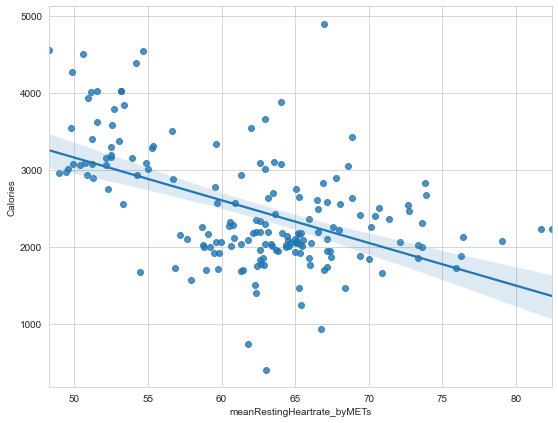

In [21]:
calc_linear_regression(dataset3['meanRestingHeartrate_byMETs'], dataset3['Calories'])

Slope: -44.892662481114705
Intercept: 5275.23671417207
Pearson R-score: -0.4388501592621009
P-value: 1.3849799255840796e-09
Standard Error: 7.008774480372944
R-squared: 0.19258946228437135


[-44.892662481114705,
 5275.23671417207,
 -0.4388501592621009,
 1.3849799255840796e-09,
 7.008774480372944]

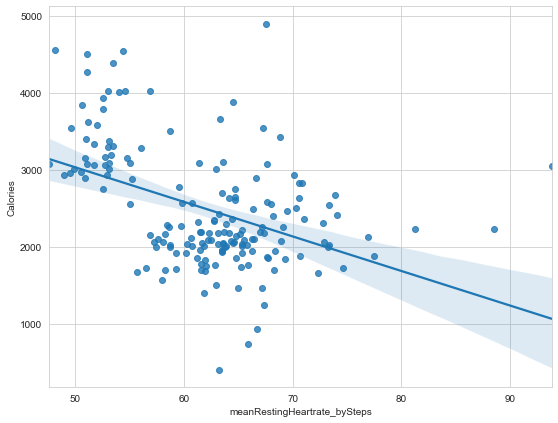

In [22]:
calc_linear_regression(dataset3['meanRestingHeartrate_bySteps'], dataset3['Calories'])

In [23]:
dataset3_weightsAndScores = generate_activity_minutes_weights(dataset3, ['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes'], ['Calories'])

Trial 1
r2 score is: 0.466636576605278
mean_sqrd_error is: 284512.98008230014
root_mean_squared_error of is: 533.3975816239704
Trial 2
r2 score is: 0.7486121140571351
mean_sqrd_error is: 189735.41036728243
root_mean_squared_error of is: 435.58628349304394
Trial 3
r2 score is: 0.548842464993136
mean_sqrd_error is: 195315.10311374578
root_mean_squared_error of is: 441.9446833187902


In [24]:
dataset3_weights = generate_mean_weights(dataset3_weightsAndScores)

In [25]:
dataset1_weightsAndScores = generate_activity_minutes_weights(dataset1, ['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes'], ['Calories'])

Trial 1
r2 score is: 0.3310619245682923
mean_sqrd_error is: 278955.6965547794
root_mean_squared_error of is: 528.1625664080893
Trial 2
r2 score is: 0.4426029053276074
mean_sqrd_error is: 260926.74962731547
root_mean_squared_error of is: 510.80989578052953
Trial 3
r2 score is: 0.3325216290049722
mean_sqrd_error is: 273339.36191864393
root_mean_squared_error of is: 522.818670208557


### Comparing the weights and results for each dataset

In [26]:
dataset1_weightsAndScores

,coef1,coef2,coef3,r2_score,mean_squared_error,root_mean_squared_error
0,13.249393,1.993473,1.739591,0.331062,278955.696555,528.162566
1,12.425899,4.481513,1.572228,0.442603,260926.749627,510.809896
2,13.006922,2.195793,1.596233,0.332522,273339.361919,522.818670


In [27]:
dataset2_weightsAndScores

,coef1,coef2,coef3,r2_score,mean_squared_error,root_mean_squared_error
0,14.514064,-2.337481,2.262889,0.317887,367758.669980,606.431093
1,13.691351,-1.643250,2.075721,0.446048,335750.473797,579.439793
2,15.249017,-2.407782,2.350000,0.418190,293405.227836,541.668928


In [28]:
dataset3_weightsAndScores

,coef1,coef2,coef3,r2_score,mean_squared_error,root_mean_squared_error
0,11.322943,6.963368,2.129178,0.466637,284512.980082,533.397582
1,11.197550,6.646757,2.337534,0.748612,189735.410367,435.586283
2,11.415761,6.373835,2.151841,0.548842,195315.103114,441.944683


In [29]:
print(dataset1_weights)
print(dataset2_weights)
print(dataset3_weights)

[12.89, 2.89, 1.64]
[14.48, -2.13, 2.23]
[11.31, 6.66, 2.21]


### Adding weighted Activity features to dataset 1, 2, and 3

In [30]:
dataset1 = add_weightedActivity_columns(dataset1, dataset1_weights)
dataset2 = add_weightedActivity_columns(dataset2, dataset2_weights)
dataset3 = add_weightedActivity_columns(dataset3, dataset3_weights)

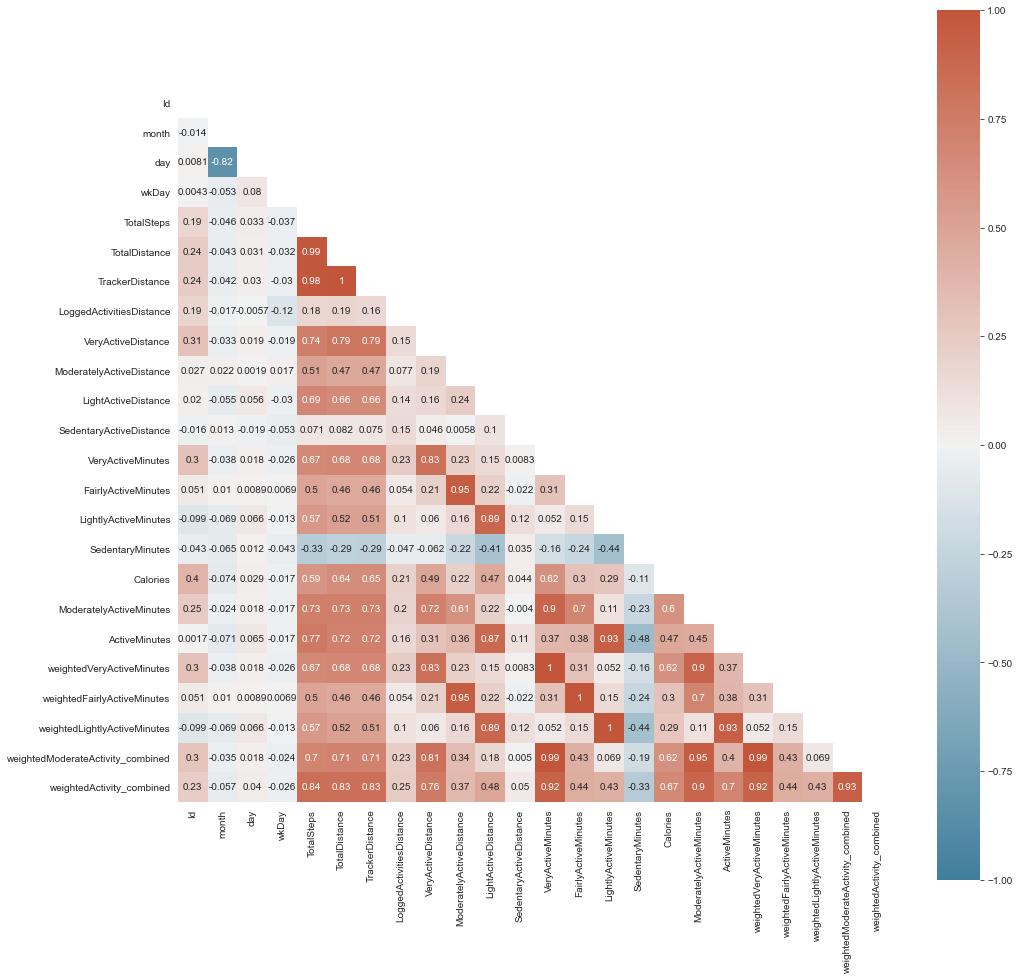

In [31]:
plot_corr_matrix(dataset1)

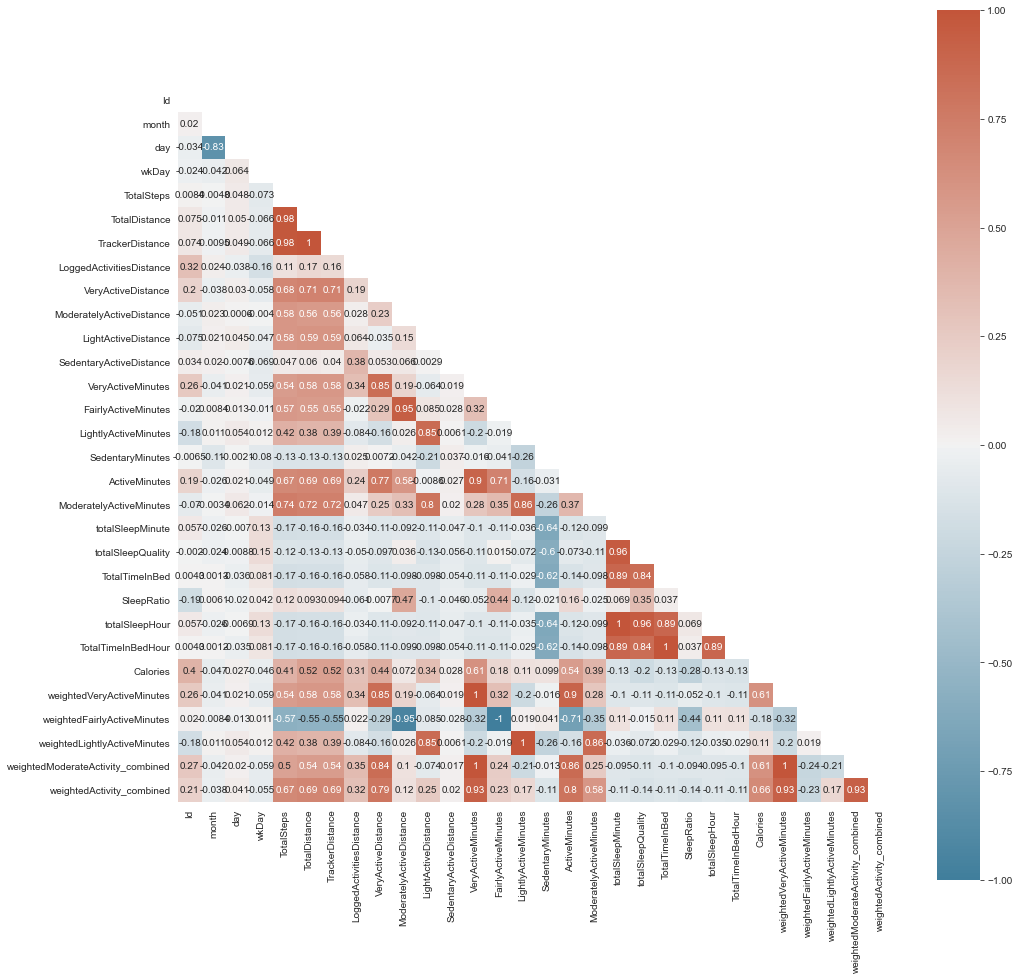

In [32]:
plot_corr_matrix(dataset2)

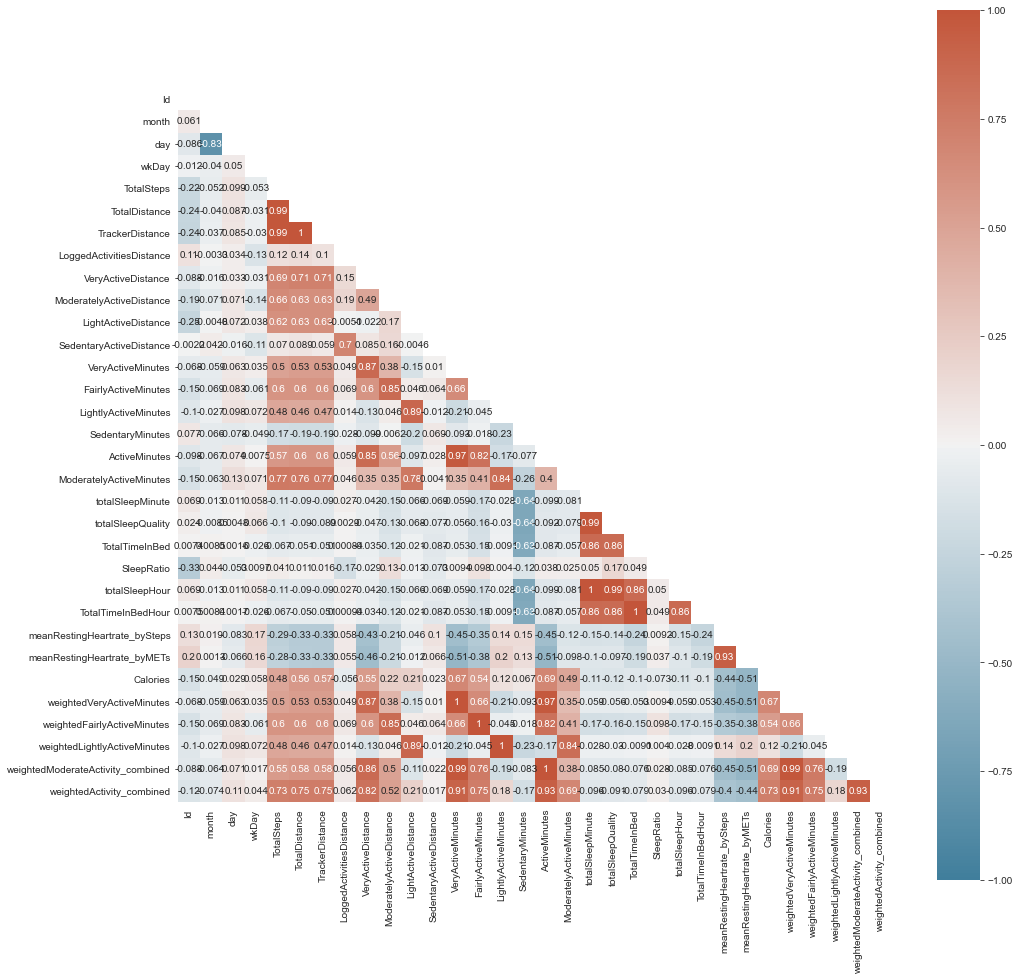

In [33]:
plot_corr_matrix(dataset3)

# 3 TESTS
- 1) Linear Regression without Dummy Variables Testing Square root MSE
- 2) Using XGboost for potential feature selection
- 3) Linear Regression using features selected from test 2 

## Test 1

In [34]:
def dataset_test1(_df, drop_columns):
    df = _df.copy()
    df = df.drop(columns = drop_columns)
    
    y = _df['Calories']
    x = df.drop('Calories',axis=1)
    x_cols = x.columns
#     x=x.to_numpy()
    
    # create a list of 3 random states to loop through
    random_states = [23, 7, 45]
    
    ### LR first without dummy ###
    print('### First Test ###')
    print('No Dummy Variables')

    trial1_results = []

    for i, item in enumerate(random_states):
        # splitting the data
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=item)
        # creating an object of LinearRegression class
        LR = LinearRegression()
        # fitting the training data
        LR.fit(x_train,y_train)
        
        y_prediction =  LR.predict(x_test)
        # predicting the accuracy score
        score=r2_score(y_test, y_prediction)
        trial_results_cols = ['r2_score', 'mean_squared_error', 'root_mean_squared_error']
        trial1_results.append([score, mean_squared_error(y_test,y_prediction), np.sqrt(mean_squared_error(y_test,y_prediction))])
        trial1_results_df = pd.DataFrame(trial1_results, columns=trial_results_cols)
        
        print(f'Trial {i+1}')
        print('r2 score is:',score)
        print('mean_sqrd_error is:',mean_squared_error(y_test,y_prediction))
        print('root_mean_squared_error of is:', np.sqrt(mean_squared_error(y_test,y_prediction)))
        
    test1_results_df = pd.DataFrame(trial1_results, columns=trial_results_cols)
    return test1_results_df

In [35]:
drop_columns1 = ['Id', 'dtString', 'month', 'day', 'wkDay', 'Id_dt_string']
dataset_test1(dataset1, drop_columns1)

### First Test ###
No Dummy Variables
Trial 1
r2 score is: 0.7581550294698285
mean_sqrd_error is: 100852.43266945942
root_mean_squared_error of is: 317.57272028538506
Trial 2
r2 score is: 0.7346738943603902
mean_sqrd_error is: 124203.51486852851
root_mean_squared_error of is: 352.42519045682377
Trial 3
r2 score is: 0.6774102547032936
mean_sqrd_error is: 132103.8687882164
root_mean_squared_error of is: 363.46095909769514


,r2_score,mean_squared_error,root_mean_squared_error
0,0.758155,100852.432669,317.572720
1,0.734674,124203.514869,352.425190
2,0.677410,132103.868788,363.460959


In [36]:
drop_columns2 = ['Id', 'dtString', 'month', 'day', 'wkDay', 'Id_month_day']
dataset_test1(dataset2, drop_columns2)

### First Test ###
No Dummy Variables
Trial 1
r2 score is: 0.798215203639014
mean_sqrd_error is: 108791.55740825104
root_mean_squared_error of is: 329.8356521182194
Trial 2
r2 score is: 0.8585972949340436
mean_sqrd_error is: 85704.15708091507
root_mean_squared_error of is: 292.7527234389376
Trial 3
r2 score is: 0.8527230900102762
mean_sqrd_error is: 74271.33550526411
root_mean_squared_error of is: 272.5276784204938


,r2_score,mean_squared_error,root_mean_squared_error
0,0.798215,108791.557408,329.835652
1,0.858597,85704.157081,292.752723
2,0.852723,74271.335505,272.527678


In [37]:
drop_columns3 = ['Id', 'dtString', 'month', 'day', 'wkDay', 'Id_month_day']
dataset_test1(dataset3, drop_columns3)

### First Test ###
No Dummy Variables
Trial 1
r2 score is: 0.8522882646653271
mean_sqrd_error is: 78794.1282994466
root_mean_squared_error of is: 280.702918223959
Trial 2
r2 score is: 0.9268026622031069
mean_sqrd_error is: 55245.808176463084
root_mean_squared_error of is: 235.0442685462955
Trial 3
r2 score is: 0.8360292275496122
mean_sqrd_error is: 70986.22065195208
root_mean_squared_error of is: 266.43239414897


,r2_score,mean_squared_error,root_mean_squared_error
0,0.852288,78794.128299,280.702918
1,0.926803,55245.808176,235.044269
2,0.836029,70986.220652,266.432394


# Test 2

In [38]:
def dataset_test2(_df, drop_columns, dummy_variables=True, param_options=1, visualize=False):
    ### test with dummy and xgboost ###
    df = _df.copy()
    df = df.drop(columns = drop_columns)
    
    y = df['Calories']
    x = df.drop('Calories',axis=1)
    x_cols = x.columns
#     x=x.to_numpy()
    
    # create a list of 3 random states to loop through
    random_states = [23, 7, 45]
    
    
    trial2_results = []
    
    if dummy_variables:
        # adds the wkDay dummy variables
        print('XGBoost with dummy variables')
        x['wkDay'] = _df['wkDay'].astype('category')
        cats = pd.get_dummies(x)
        seen = set()
        x_cols = x.columns.to_list()
        dupes = [x for x in x_cols if x in seen or seen.add(x)]
        # handle categorical variable
        cats = cats.drop(columns=dupes, axis=1)
        # dropping extra column
        x = x.drop(['wkDay'],axis=1)
        # concatation of independent variables and new cateorical variable.
        x = pd.concat([x,cats],axis=1)
        x = x.loc[:,~x.columns.duplicated()]
        x_cols = x.columns
        
    else:
        print('XGBoost without dummy variables')
        
    # xgboost
    data_dmatrix = xgb.DMatrix(data=x,label=y)
    
    feature_importances_df = pd.DataFrame()
    
    for i, item in enumerate(random_states):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=item)
        xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
        xg_reg.fit(x_train, y_train)

        preds = xg_reg.predict(x_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        print("RMSE: %f" % (rmse))

        # different parameter preset options
        if param_options == 1:
            params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,
                      'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}
        else:
            params = {'objective':'reg:squarederror','max_depth': 6, 
                      'colsample_bytree': 0.8, 'colsample_bylevel':0.8,
                      'learning_rate':0.1, 'alpha': 10, 'random_state': 23}

        cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=item)

        print(f'root_mean_squared_error from gxboost is: {(cv_results["test-rmse-mean"].iloc[-1])}')

        trial_features = pd.DataFrame([xg_reg.feature_importances_.argsort(), x_cols]).T
        trial_features = trial_features.sort_values(by=0, ascending=False)
        trial_features.columns = [f'trial_{i+1}', i+1]
#         return trial_features

        
        feature_importances_df = pd.concat([feature_importances_df, trial_features], axis=1)

        if visualize:
            xgb.plot_tree(xg_reg,num_trees=0)
            plt.rcParams['figure.figsize'] = (12, 10)
            plt.show()

            xgb.plot_importance(xg_reg)
            plt.rcParams['figure.figsize'] = (6, 6)
            plt.show()

    feature_importances_df['total_points'] = feature_importances_df[['trial_1', 'trial_2', 'trial_3']].apply(lambda x: x.values.sum(), axis="columns")
    feature_importances_df = feature_importances_df.sort_values(by='total_points', ascending=False)
    feature_importances_df = feature_importances_df[[3, 'total_points']]
    feature_importances_df.columns = ['features', 'total_points']
    feature_importances_df = feature_importances_df.reset_index(drop=True)
    
    return feature_importances_df

## Test 2a
Feature selection and test with dummy variables for wkDay

In [39]:
drop_columns1 = ['Id', 'dtString', 'month', 'day', 'wkDay', 'Id_dt_string']
dataset_test2(dataset1, drop_columns1)

XGBoost with dummy variables
RMSE: 916.241747
root_mean_squared_error from gxboost is: 432.28846233333337
RMSE: 950.188708
root_mean_squared_error from gxboost is: 433.061971
RMSE: 975.802796
root_mean_squared_error from gxboost is: 427.40877266666666


,features,total_points
0,TotalSteps,75
1,ModeratelyActiveDistance,67
2,LoggedActivitiesDistance,63
3,wkDay_5,54
4,wkDay_6,51
5,ActiveMinutes,48
6,TrackerDistance,47
7,wkDay_4,45
8,LightActiveDistance,45
9,wkDay_3,42


In [40]:
drop_columns2 = ['Id', 'dtString', 'month', 'day', 'wkDay', 'Id_month_day']
dataset_test2(dataset2, drop_columns2)

XGBoost with dummy variables
RMSE: 1058.835166
root_mean_squared_error from gxboost is: 428.32179733333334
RMSE: 1053.403962
root_mean_squared_error from gxboost is: 408.4242963333333
RMSE: 1035.668175
root_mean_squared_error from gxboost is: 430.253184


,features,total_points
0,TotalSteps,93
1,TotalDistance,79
2,VeryActiveDistance,72
3,ActiveMinutes,69
4,wkDay_6,69
5,ModeratelyActiveMinutes,64
6,LightActiveDistance,61
7,wkDay_2,60
8,totalSleepMinute,59
9,FairlyActiveMinutes,57


In [41]:
drop_columns3 = ['Id', 'dtString', 'month', 'day', 'wkDay', 'Id_month_day']
dataset_test2(dataset3, drop_columns3)

XGBoost with dummy variables
RMSE: 1039.470459
root_mean_squared_error from gxboost is: 418.73247266666664
RMSE: 1124.941509
root_mean_squared_error from gxboost is: 454.846008
RMSE: 970.408686
root_mean_squared_error from gxboost is: 438.91002399999996


,features,total_points
0,TotalSteps,99
1,FairlyActiveMinutes,88
2,SedentaryActiveDistance,85
3,TotalDistance,77
4,LoggedActivitiesDistance,74
5,VeryActiveDistance,68
6,ModeratelyActiveDistance,66
7,SedentaryMinutes,64
8,wkDay_6,62
9,wkDay_0,60


## Test 2b
Feature selection and test without dummy variables.  
After seeing the results of xgboost with the dummy variables and the estimated significance of certain days of the week, a second round of test 2's were conducted without the wkDay dummy variables to see the impact of the other features on their predictive quality.

In [42]:
drop_columns1 = ['Id', 'dtString', 'month', 'day', 'wkDay', 'Id_dt_string']
dataset1_features = dataset_test2(dataset1, drop_columns1, dummy_variables=False)
dataset1_features

XGBoost without dummy variables
RMSE: 918.989870
root_mean_squared_error from gxboost is: 431.441579
RMSE: 951.609761
root_mean_squared_error from gxboost is: 434.43318666666664
RMSE: 975.973124
root_mean_squared_error from gxboost is: 424.280914


,features,total_points
0,weightedActivity_combined,54
1,weightedModerateActivity_combined,51
2,VeryActiveMinutes,36
3,weightedFairlyActiveMinutes,36
4,FairlyActiveMinutes,35
5,LoggedActivitiesDistance,32
6,SedentaryActiveDistance,31
7,LightActiveDistance,30
8,weightedVeryActiveMinutes,30
9,LightlyActiveMinutes,27


In [43]:
drop_columns2 = ['Id', 'dtString', 'month', 'day', 'wkDay', 'Id_month_day']
dataset2_features = dataset_test2(dataset2, drop_columns2, dummy_variables=False)
dataset2_features

XGBoost without dummy variables
RMSE: 1059.571509
root_mean_squared_error from gxboost is: 420.677297
RMSE: 1050.172326
root_mean_squared_error from gxboost is: 411.78679400000004
RMSE: 1036.143756
root_mean_squared_error from gxboost is: 416.7102763333333


,features,total_points
0,weightedLightlyActiveMinutes,72
1,weightedActivity_combined,69
2,TotalSteps,63
3,weightedModerateActivity_combined,60
4,LightlyActiveMinutes,56
5,totalSleepMinute,49
6,ModeratelyActiveMinutes,47
7,ActiveMinutes,43
8,weightedFairlyActiveMinutes,42
9,LoggedActivitiesDistance,41


In [44]:
drop_columns3 = ['Id', 'dtString', 'month', 'day', 'wkDay', 'Id_month_day']
dataset3_features = dataset_test2(dataset3, drop_columns3, dummy_variables=False)
dataset3_features

XGBoost without dummy variables
RMSE: 1033.248776
root_mean_squared_error from gxboost is: 413.3855083333333
RMSE: 1113.923990
root_mean_squared_error from gxboost is: 459.13672900000006
RMSE: 959.906998
root_mean_squared_error from gxboost is: 429.68728633333336


,features,total_points
0,meanRestingHeartrate_byMETs,76
1,weightedLightlyActiveMinutes,64
2,FairlyActiveMinutes,59
3,meanRestingHeartrate_bySteps,59
4,ModeratelyActiveDistance,57
5,SedentaryActiveDistance,53
6,weightedActivity_combined,52
7,TotalTimeInBedHour,48
8,VeryActiveDistance,46
9,weightedModerateActivity_combined,45


# Test 3
Linear Regression with filtered features and dummy variables.  
Features are hand selected to reduce redundancy and maximize efficacy.

## Test 3a
The top 10 features selected from the xgboost model above are included, plus the wkDay dummy variables are included

In [45]:
def dataset_test3(_df, selected_features, dummy_variables=True):
    df = _df.copy()
    y = df['Calories']
    df = df[selected_features]
    
#     x = df.drop('Calories',axis=1)
    x = df
    x_cols = x.columns
#     x=x.to_numpy()
    
    # create a list of 3 random states to loop through
    random_states = [23, 7, 45]
    
#     if dummy_variables:
    # adds the wkDay dummy variables
    print('Linear Regression with dummy variables')
    x['wkDay'] = _df['wkDay'].astype('category')
    cats = pd.get_dummies(x)
    seen = set()
    x_cols = x.columns.to_list()
    dupes = [x for x in x_cols if x in seen or seen.add(x)]
    # handle categorical variable
    cats = cats.drop(columns=dupes, axis=1)
    # dropping extra column
    x = x.drop(['wkDay'],axis=1)
    # concatation of independent variables and new cateorical variable.
    x = pd.concat([x,cats],axis=1)
    x = x.loc[:,~x.columns.duplicated()]
    x_cols = x.columns
        
#     else:
#         print('Linear Regression without dummy variables')

    trial_results = []

    for i, item in enumerate(random_states):
        # splitting the data
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=item)
        # creating an object of LinearRegression class
        LR = LinearRegression()
        # fitting the training data
        LR.fit(x_train,y_train)
        
        y_prediction =  LR.predict(x_test)
        # predicting the accuracy score
        score=r2_score(y_test, y_prediction)
        trial_results_cols = ['r2_score', 'mean_squared_error', 'root_mean_squared_error']
        trial_results.append([score, mean_squared_error(y_test,y_prediction), np.sqrt(mean_squared_error(y_test,y_prediction))])
        trial_results_df = pd.DataFrame(trial_results, columns=trial_results_cols)
        
        print(f'Trial {i+1}')
        print('r2 score is:',score)
        print('mean_sqrd_error is:',mean_squared_error(y_test,y_prediction))
        print('root_mean_squared_error of is:', np.sqrt(mean_squared_error(y_test,y_prediction)))
        
    test3_results_df = pd.DataFrame(trial_results, columns=trial_results_cols)
    return test3_results_df

In [46]:
selected_features1 = dataset1_features['features'].to_list()[:10]
selected_features1
dataset_test3(dataset1, selected_features1, dummy_variables=True)

Linear Regression with dummy variables
Trial 1
r2 score is: 0.47417377957937457
mean_sqrd_error is: 219276.23044859464
root_mean_squared_error of is: 468.2693994364725
Trial 2
r2 score is: 0.5404633315936183
mean_sqrd_error is: 215116.67421287234
root_mean_squared_error of is: 463.80672075000416
Trial 3
r2 score is: 0.41861789919045644
mean_sqrd_error is: 238082.04036529767
root_mean_squared_error of is: 487.93651263796363


,r2_score,mean_squared_error,root_mean_squared_error
0,0.474174,219276.230449,468.269399
1,0.540463,215116.674213,463.806721
2,0.418618,238082.040365,487.936513


In [47]:
selected_features2 = dataset2_features['features'].to_list()[:10]
selected_features2
dataset_test3(dataset2, selected_features2, dummy_variables=True)


Linear Regression with dummy variables
Trial 1
r2 score is: 0.3011402238590801
mean_sqrd_error is: 376787.77007727197
root_mean_squared_error of is: 613.8304082377085
Trial 2
r2 score is: 0.45753960263071225
mean_sqrd_error is: 328785.16068435577
root_mean_squared_error of is: 573.3979078130262
Trial 3
r2 score is: 0.46577779880758785
mean_sqrd_error is: 269406.76812061603
root_mean_squared_error of is: 519.0440907289245


,r2_score,mean_squared_error,root_mean_squared_error
0,0.301140,376787.770077,613.830408
1,0.457540,328785.160684,573.397908
2,0.465778,269406.768121,519.044091


In [48]:
selected_features3 = dataset3_features['features'].to_list()[:10]
selected_features3
dataset_test3(dataset3, selected_features3, dummy_variables=True)

Linear Regression with dummy variables
Trial 1
r2 score is: 0.672035427635727
mean_sqrd_error is: 174946.71316394553
root_mean_squared_error of is: 418.26631846700917
Trial 2
r2 score is: 0.7674977922344817
mean_sqrd_error is: 175481.4144533437
root_mean_squared_error of is: 418.9050184150862
Trial 3
r2 score is: 0.6498311058983952
mean_sqrd_error is: 151595.10448526742
root_mean_squared_error of is: 389.3521599853626


,r2_score,mean_squared_error,root_mean_squared_error
0,0.672035,174946.713164,418.266318
1,0.767498,175481.414453,418.905018
2,0.649831,151595.104485,389.352160


## Test 3b
After a noticable drop in performance using only the top 10 features in each of the datasets, plus the dummy variables. Test 3b will include all the features and dummy variables.

In [49]:
selected_features1 = dataset1_features['features'].to_list()
selected_features1
dataset_test3(dataset1, selected_features1, dummy_variables=True)

Linear Regression with dummy variables
Trial 1
r2 score is: 0.7487986086934365
mean_sqrd_error is: 104754.17928965838
root_mean_squared_error of is: 323.65750306405437
Trial 2
r2 score is: 0.7235518938656678
mean_sqrd_error is: 129409.90626557545
root_mean_squared_error of is: 359.7358840393539
Trial 3
r2 score is: 0.6751669370760311
mean_sqrd_error is: 133022.53077857074
root_mean_squared_error of is: 364.7225394441242


,r2_score,mean_squared_error,root_mean_squared_error
0,0.748799,104754.179290,323.657503
1,0.723552,129409.906266,359.735884
2,0.675167,133022.530779,364.722539


In [50]:
selected_features2 = dataset2_features['features'].to_list()
selected_features2
dataset_test3(dataset2, selected_features2, dummy_variables=True)

Linear Regression with dummy variables
Trial 1
r2 score is: 0.7830761296136375
mean_sqrd_error is: 116953.7354843092
root_mean_squared_error of is: 341.98499306886146
Trial 2
r2 score is: 0.8561898206531338
mean_sqrd_error is: 87163.32686018564
root_mean_squared_error of is: 295.2343592134656
Trial 3
r2 score is: 0.8475390840865905
mean_sqrd_error is: 76885.61525384251
root_mean_squared_error of is: 277.2825549035541


,r2_score,mean_squared_error,root_mean_squared_error
0,0.783076,116953.735484,341.984993
1,0.856190,87163.326860,295.234359
2,0.847539,76885.615254,277.282555


In [51]:
selected_features3 = dataset3_features['features'].to_list()
selected_features3
dataset_test3(dataset3, selected_features3, dummy_variables=True)

Linear Regression with dummy variables
Trial 1
r2 score is: 0.8458201137700926
mean_sqrd_error is: 82244.4452992744
root_mean_squared_error of is: 286.78292365354395
Trial 2
r2 score is: 0.9247276746333132
mean_sqrd_error is: 56811.90837490822
root_mean_squared_error of is: 238.3524876625126
Trial 3
r2 score is: 0.8271233338282667
mean_sqrd_error is: 74841.75982737156
root_mean_squared_error of is: 273.5722204964743


,r2_score,mean_squared_error,root_mean_squared_error
0,0.845820,82244.445299,286.782924
1,0.924728,56811.908375,238.352488
2,0.827123,74841.759827,273.572220
